This was the file that was brought over to AWS Sagemaker but is also kind of outdated.

In [ ]:
import time
import sys
import os
import glob
import math
import threading
import concurrent.futures as cf
import random
import re

import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Input, Model, layers, metrics, losses, callbacks, optimizers, models, utils
from keras import backend as K
import gc
import keras_tuner as kt
from pyfaidx import Fasta

K.clear_session()
gc.collect()

datasets_path = "../../Datasets/"
models_path = "../../Models/"

0

In [13]:
class CustomNonZeroF1Score(tf.keras.metrics.Metric):
    def __init__(self, num_classes, average='weighted', threshold=0.5, name='non_zero_f1', **kwargs):
        """
        Custom F1 score metric that only considers non-dominant classes (ignoring index 0).
        
        This version is designed for multi-encoded labels where:
          - The dominant class (index 0) is represented as a hard label [1, 0, 0, ...]
          - For non-dominant classes (indices 1 to num_classes-1), only an exact label of 1 is considered positive.
            (Any partial credit/smoothed values below 1 are treated as 0.)
          - Predictions are thresholded (default threshold = 0.5) to decide 1 vs. 0.
        
        Args:
            num_classes (int): Total number of classes.
            average (str): 'weighted' (default) to weight by support or 'macro' for a simple average.
            threshold (float): Threshold on y_pred to decide a positive (default 0.5).
            name (str): Name of the metric.
            **kwargs: Additional keyword arguments.
        """
        super(CustomNonZeroF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.threshold = threshold
        if average not in ['weighted', 'macro']:
            raise ValueError("average must be 'weighted' or 'macro'")
        self.average = average

        # Create state variables to accumulate counts for each class.
        # We use a vector of length num_classes but we will update only indices 1...num_classes-1.
        self.true_positives = self.add_weight(
            name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_positives = self.add_weight(
            name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )
        self.false_negatives = self.add_weight(
            name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the metric state.
        
        Args:
            y_true: Tensor of shape (batch_size, num_classes). These are multi-encoded labels.
                    For non-dominant classes, a label is considered positive only if it is exactly 1.
            y_pred: Tensor of shape (batch_size, num_classes) with predictions (e.g. probabilities).
            sample_weight: Optional sample weights.
        """
        
        # Flatten all dimensions except the last one (which should be num_classes).
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])
        
        # We want to ignore the dominant class (index 0) and work on classes 1...num_classes-1.
        # Assume y_true and y_pred are both of shape (batch_size, num_classes).
        y_true_non_dominant = y_true[:, 1:]
        y_pred_non_dominant = y_pred[:, 1:]
        
        # For ground truth: treat a class as positive only if its value is exactly 1.
        one_value = tf.cast(1.0, dtype=y_true_non_dominant.dtype)
        y_true_bin = tf.cast(tf.equal(y_true_non_dominant, one_value), tf.int32)
        # For predictions: apply thresholding.
        y_pred_bin = tf.cast(y_pred_non_dominant >= self.threshold, tf.int32)
        
        # (Optionally) apply sample weighting.
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.int32)
            sample_weight = tf.reshape(sample_weight, (-1, 1))
            y_true_bin = y_true_bin * sample_weight
            y_pred_bin = y_pred_bin * sample_weight
        
        # Compute per-class true positives, false positives, and false negatives for non-dominant classes.
        tp = tf.reduce_sum(tf.cast(y_true_bin * y_pred_bin, tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true_bin) * y_pred_bin, tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true_bin * (1 - y_pred_bin), tf.float32), axis=0)
        
        # Our state variables have length num_classes. We want to update only indices 1... with our computed values.
        zeros = tf.zeros([1], dtype=tf.float32)
        tp_update = tf.concat([zeros, tp], axis=0)
        fp_update = tf.concat([zeros, fp], axis=0)
        fn_update = tf.concat([zeros, fn], axis=0)
        
        self.true_positives.assign_add(tp_update)
        self.false_positives.assign_add(fp_update)
        self.false_negatives.assign_add(fn_update)

    def result(self):
        """
        Computes the F1 score over the non-dominant classes (indices 1...num_classes-1).
        """
        # Select non-dominant classes only.
        tp = self.true_positives[1:]
        fp = self.false_positives[1:]
        fn = self.false_negatives[1:]
        
        precision = tf.math.divide_no_nan(tp, tp + fp)
        recall = tf.math.divide_no_nan(tp, tp + fn)
        f1 = tf.math.divide_no_nan(2 * precision * recall, precision + recall)
        
        if self.average == 'weighted':
            support = tp + fn
            weighted_f1 = tf.reduce_sum(f1 * support) / (tf.reduce_sum(support) + K.epsilon())
            return weighted_f1
        else:  # macro
            return tf.reduce_mean(f1)

    def reset_states(self):
        """
        Resets all of the metric state variables.
        """
        for v in self.variables:
            v.assign(tf.zeros_like(v))

In [14]:
# def custom_binary_crossentropy_loss(
#     dominant_class_index=0,
#     dominant_correct_multiplier=0.1,    # reward factor when the dominant class is correct
#     dominant_incorrect_multiplier=2.0,    # penalty factor when the dominant class is predicted incorrectly
#     other_class_multiplier=1.0,           # multiplier for non-dominant classes when y_true == 1
#     smoothing_multiplier=1.0              # multiplier for non-dominant classes when y_true is a smoothed value (0 < y_true < 1)
#     ):
#     """
#     Returns a custom binary crossentropy loss function that treats the dominant class specially,
#     and applies different multipliers for non-dominant classes based on their true label values.
    
#     For the dominant class (specified by dominant_class_index):
#       - If y_true == 1, the loss is scaled by dominant_correct_multiplier.
#       - Otherwise, it is scaled by dominant_incorrect_multiplier.
    
#     For non-dominant classes:
#       - If y_true == 1, the loss is scaled by other_class_multiplier.
#       - If 0 < y_true < 1 (e.g. label-smoothed values, typically in (0, 0.5]), the loss is scaled by smoothing_multiplier.
#       - If y_true == 0, no additional scaling is applied.
      
#     Parameters:
#       dominant_class_index (int): Index of the dominant class in the output vector.
#       dominant_correct_multiplier (float): Multiplier for the loss when the dominant class is correctly predicted.
#       dominant_incorrect_multiplier (float): Multiplier for the loss when the dominant class is incorrectly predicted.
#       other_class_multiplier (float): Multiplier for non-dominant classes when the true label is 1.
#       smoothing_multiplier (float): Multiplier for non-dominant classes when the true label is a smoothed value (0 < y_true < 1).
      
#     Returns:
#       A callable loss function usable with model.compile(loss=...).
#     """
#     def loss(y_true, y_pred):
#         # Prevent issues with log(0)
#         epsilon = K.epsilon()
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        
 
#         # Compute standard element-wise binary crossentropy.
#         base_loss = - (y_true * tf.math.log(y_pred) +
#                        (1 - y_true) * tf.math.log(1 - y_pred))
        
#         # Determine the number of classes.
#         num_classes = tf.shape(y_true)[1]
        
#         # Create a one-hot mask for the dominant class.
#         dominant_mask = tf.one_hot(dominant_class_index, depth=num_classes, dtype=y_true.dtype)
#         # The complement selects all non-dominant columns.
#         non_dominant_mask = 1 - dominant_mask
        
#         # --- Dominant Class Weighting ---
#         # For the dominant class: if y_true == 1 use dominant_correct_multiplier; otherwise use dominant_incorrect_multiplier.
#         dominant_true = y_true[:, dominant_class_index]  # Shape: (batch_size,)
#         dominant_weight = tf.where(tf.equal(dominant_true, 1.0),
#                                    dominant_correct_multiplier,
#                                    dominant_incorrect_multiplier)  # Shape: (batch_size,)
#         dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # Shape: (batch_size, 1)
        
#         # --- Non-Dominant Class Weighting ---
#         # For non-dominant classes, apply:
#         #   - other_class_multiplier if y_true == 1
#         #   - smoothing_multiplier if 0 < y_true < 1 (i.e. a smoothed value)
#         #   - otherwise (y_true == 0) leave as 1.
#         non_dominant_weight = tf.where(
#             tf.equal(y_true, 1.0),
#             other_class_multiplier,
#             tf.where(tf.greater(y_true, 0.0),
#                      smoothing_multiplier,
#                      1.0)
#         )
        
#         # Combine the weights for each class.
#         weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
#         # Compute and return the weighted loss.
#         weighted_loss = base_loss * weights
#         return tf.reduce_mean(weighted_loss)
    
#     return loss



# def custom_binary_crossentropy_loss(
#     dominant_class_index=0,
#     dominant_correct_multiplier=0.1,    # Reward factor when the dominant class is correct
#     dominant_incorrect_multiplier=2.0,    # Penalty factor when the dominant class is predicted incorrectly
#     other_class_multiplier=1.0,           # Multiplier for non-dominant classes when y_true == 1
#     smoothing_multiplier=1.0              # Multiplier for non-dominant classes when y_true is a smoothed value (0 < y_true < 1)
# ):
#     """
#     Returns a custom binary crossentropy loss function that treats the dominant class specially,
#     and applies different multipliers for non-dominant classes based on their true label values.

#     For the dominant class (specified by dominant_class_index):
#       - If y_true == 1, the loss is scaled by dominant_correct_multiplier.
#       - Otherwise, it is scaled by dominant_incorrect_multiplier.

#     For non-dominant classes:
#       - If y_true == 1, the loss is scaled by other_class_multiplier.
#       - If 0 < y_true < 1 (e.g. label-smoothed values), the loss is scaled by smoothing_multiplier.
#       - If y_true == 0, no additional scaling is applied.

#     This version also reshapes the inputs so that it can handle batches with extra dimensions.

#     Parameters:
#       dominant_class_index (int): Index of the dominant class in the output vector.
#       dominant_correct_multiplier (float): Multiplier for the loss when the dominant class is correctly predicted.
#       dominant_incorrect_multiplier (float): Multiplier for the loss when the dominant class is incorrectly predicted.
#       other_class_multiplier (float): Multiplier for non-dominant classes when the true label is 1.
#       smoothing_multiplier (float): Multiplier for non-dominant classes when the true label is a smoothed value (0 < y_true < 1).

#     Returns:
#       A callable loss function usable with model.compile(loss=...).
#     """
#     def loss(y_true, y_pred):
#         # Prevent log(0) issues.
#         epsilon = K.epsilon()
#         y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
#         # Flatten all dimensions except the last one (which should represent the classes).
#         y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
#         y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
#         # Compute the standard element-wise binary crossentropy.
#         base_loss = - (y_true * tf.math.log(y_pred) +
#                        (1 - y_true) * tf.math.log(1 - y_pred))
        
#         # Determine the number of classes.
#         num_classes = tf.shape(y_true)[1]
        
#         # Create a one-hot mask for the dominant class.
#         # This yields a tensor of shape (num_classes,).
#         dominant_mask = tf.one_hot(dominant_class_index, depth=num_classes, dtype=y_true.dtype)
#         non_dominant_mask = 1 - dominant_mask
        
#         # --- Dominant Class Weighting ---
#         # For the dominant class: if y_true == 1, use dominant_correct_multiplier; otherwise, use dominant_incorrect_multiplier.
#         dominant_true = y_true[:, dominant_class_index]  # Shape: (N,)
#         dominant_weight = tf.where(tf.equal(dominant_true, 1.0),
#                                    dominant_correct_multiplier,
#                                    dominant_incorrect_multiplier)  # Shape: (N,)
#         dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # Shape: (N, 1)
        
#         # --- Non-Dominant Class Weighting ---
#         # For non-dominant classes:
#         #   - If y_true == 1, use other_class_multiplier.
#         #   - If 0 < y_true < 1 (i.e. a smoothed value), use smoothing_multiplier.
#         #   - Otherwise (y_true == 0) use 1.
#         non_dominant_weight = tf.where(
#             tf.equal(y_true, 1.0),
#             other_class_multiplier,
#             tf.where(tf.greater(y_true, 0.0),
#                      smoothing_multiplier,
#                      1.0)
#         )
        
#         # Reshape the masks so they broadcast properly with the batch.
#         dominant_mask = tf.reshape(dominant_mask, [1, num_classes])
#         non_dominant_mask = tf.reshape(non_dominant_mask, [1, num_classes])
        
#         # Combine the weights: for each sample and each class,
#         # the weight is dominant_weight for the dominant class and non_dominant_weight for the others.
#         weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
#         # Compute the weighted loss.
#         weighted_loss = base_loss * weights
#         return tf.reduce_mean(weighted_loss)
    
#     return loss


@utils.register_keras_serializable()
class CustomBinaryCrossentropyLoss(losses.Loss):
    def __init__(self,
                 dominant_class_index=0,
                 # Multiplier n values (0 < n < 1) reward the loss function, n = 1 makes no effect, n > 1 scales up the punishment. n > 5 is likely to cause instability
                 # Shouldn't set to 0 or lower because 0 kills any signal for the gradient to use and negative numbers get weird with logs 
                 dominant_correct_multiplier=0.99,    # "Reward" factor when the dominant class is correct
                 dominant_incorrect_multiplier=2.5,     # Penalty factor when the dominant class is predicted incorrectly
                 # Expanded non-dominant multipliers for hard labels:
                 other_class_true_positive_multiplier=0.05,   # "Reward" when y_true==1 and prediction is positive (Strong reward for a bulls-eye)
                 other_class_false_negative_multiplier=3.0,    # Punish when y_true==1 but prediction is negative (Punish a miss on a rare opportunity to find a target)
                 other_class_false_positive_multiplier=1.0,    # Punish when y_true==0 but prediction is positive (Keeping neutral for now, no shame in guessing)
                 other_class_true_negative_multiplier=0.99,     # Neutral when y_true==0 and prediction is negative (Small reward for an easy correct guess)
                 # For smoothed labels (0 < y_true < 1)
                 smoothing_multiplier=0.5,              # Scales the effect of the smoothed label. Pair decimals with smoothing_as_correct = True, n > 1 for False (Current setting rewards getting close to the target)
                 smoothing_as_correct=True,             # If True, treat a high prediction as rewarded; if False, as punished
                 threshold=0.5,                         # Threshold to decide if a prediction is “positive”
                 name="custom_binary_crossentropy_loss",
                 reduction="sum_over_batch_size"):
        super().__init__(name=name)
        self.dominant_class_index = dominant_class_index
        self.dominant_correct_multiplier = dominant_correct_multiplier
        self.dominant_incorrect_multiplier = dominant_incorrect_multiplier

        self.other_class_true_positive_multiplier = other_class_true_positive_multiplier
        self.other_class_false_negative_multiplier = other_class_false_negative_multiplier
        self.other_class_false_positive_multiplier = other_class_false_positive_multiplier
        self.other_class_true_negative_multiplier = other_class_true_negative_multiplier

        self.smoothing_multiplier = smoothing_multiplier
        self.smoothing_as_correct = smoothing_as_correct
        self.threshold = threshold

    def call(self, y_true, y_pred):
        # Prevent log(0) issues.
        epsilon = K.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # Reshape to (batch_size, num_classes)
        y_true = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
        y_pred = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
        
        # Compute standard binary crossentropy (elementwise).
        base_loss = - (y_true * tf.math.log(y_pred) +
                       (1 - y_true) * tf.math.log(1 - y_pred))
        
        # Get number of classes.
        num_classes = tf.shape(y_true)[1]
        
        # Create masks for the dominant class vs. non-dominant.
        dominant_mask = tf.one_hot(self.dominant_class_index, depth=num_classes, dtype=tf.float32)
        non_dominant_mask = tf.cast(tf.constant(1.0, tf.float32) - dominant_mask, tf.float32)
        
        # --- Dominant Class Weighting ---
        # For the dominant class, use one multiplier if the true label is 1,
        # and another if it is 0.
        dominant_true = y_true[:, self.dominant_class_index]  # shape: (batch_size,)
        dominant_weight = tf.where(
            tf.equal(dominant_true, tf.constant(1.0, dtype=y_true.dtype)),
            tf.constant(self.dominant_correct_multiplier, dtype=y_true.dtype),
            tf.constant(self.dominant_incorrect_multiplier, dtype=y_true.dtype)
        )
        dominant_weight = tf.expand_dims(dominant_weight, axis=1)  # shape: (batch_size, 1)
        
        # --- Non-Dominant Class Weighting ---
        # For non-dominant classes, we now treat hard labels (exactly 0 or 1) separately
        # from smoothed labels (0 < y_true < 1).
        
        # Determine conditions for hard labels.
        is_hard_positive = tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype))
        is_hard_negative = tf.equal(y_true, tf.constant(0.0, dtype=y_true.dtype))
        is_hard = tf.logical_or(is_hard_positive, is_hard_negative)
        
        # Determine prediction condition: is the prediction "positive"?
        pred_positive = tf.greater_equal(y_pred, tf.constant(self.threshold, dtype=y_true.dtype))
        
        # For hard labels:
        # If y_true is 1:
        #    - If prediction is positive: true positive multiplier.
        #    - Else: false negative multiplier.
        # If y_true is 0:
        #    - If prediction is positive: false positive multiplier.
        #    - Else: true negative multiplier.
        hard_weight = tf.where(
            tf.equal(y_true, tf.constant(1.0, dtype=y_true.dtype)),
            tf.where(
                pred_positive,
                tf.constant(self.other_class_true_positive_multiplier, dtype=y_true.dtype),
                tf.constant(self.other_class_false_negative_multiplier, dtype=y_true.dtype)
            ),
            tf.where(
                tf.equal(y_true, tf.constant(0.0, dtype=y_true.dtype)),
                tf.where(
                    pred_positive,
                    tf.constant(self.other_class_false_positive_multiplier, dtype=y_true.dtype),
                    tf.constant(self.other_class_true_negative_multiplier, dtype=y_true.dtype)
                ),
                tf.constant(1.0, dtype=y_true.dtype)  # fallback, should not occur for a hard label.
            )
        )
        
        # For smoothed labels: (values strictly between 0 and 1)
        is_smoothed = tf.logical_and(
            tf.greater(y_true, tf.constant(0.0, dtype=y_true.dtype)),
            tf.less(y_true, tf.constant(1.0, dtype=y_true.dtype))
        )
        # Here, we modulate the weight using the label’s value and a multiplier.
        # We let the toggle smoothing_as_correct decide which way to go.
        if self.smoothing_as_correct:
            smoothed_weight = tf.where(
                pred_positive,
                1.0 - y_true * self.smoothing_multiplier,  # reward by lowering the loss
                1.0 + y_true * self.smoothing_multiplier   # punish by increasing the loss
            )
        else:
            smoothed_weight = tf.where(
                pred_positive,
                1.0 + y_true * self.smoothing_multiplier,  # punish
                1.0 - y_true * self.smoothing_multiplier   # reward
            )
        # Combine the hard and smoothed weights for non-dominant classes.
        non_dominant_weight = tf.where(
            is_hard,
            hard_weight,
            tf.where(
                is_smoothed,
                smoothed_weight,
                tf.constant(1.0, dtype=y_true.dtype)  # fallback
            )
        )
        
        # Reshape the masks so they broadcast properly.
        dominant_mask = tf.reshape(dominant_mask, tf.stack([tf.constant(1, dtype=tf.int32), num_classes]))
        non_dominant_mask = tf.reshape(non_dominant_mask, tf.stack([tf.constant(1, dtype=tf.int32), num_classes]))
        
        # Combine weights: dominant classes get their weight; non-dominant get their own.
        # dominant_weight has shape (batch_size, 1) and will broadcast.
        weights = dominant_mask * dominant_weight + non_dominant_mask * non_dominant_weight
        
        # Compute weighted loss.
        weighted_loss = base_loss * weights
        return tf.reduce_mean(weighted_loss)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'dominant_class_index': self.dominant_class_index,
            'dominant_correct_multiplier': self.dominant_correct_multiplier,
            'dominant_incorrect_multiplier': self.dominant_incorrect_multiplier,
            'other_class_true_positive_multiplier': self.other_class_true_positive_multiplier,
            'other_class_false_negative_multiplier': self.other_class_false_negative_multiplier,
            'other_class_false_positive_multiplier': self.other_class_false_positive_multiplier,
            'other_class_true_negative_multiplier': self.other_class_true_negative_multiplier,
            'smoothing_multiplier': self.smoothing_multiplier,
            'smoothing_as_correct': self.smoothing_as_correct,
            'threshold': self.threshold
        })
        return config


In [15]:
def create_dcnn_model(
    input_dim=5,
    sequence_length=5000,
    num_classes=5
):
    inputs = Input(shape=(sequence_length, input_dim))
    
    # Condensed positional encoding block.  See cnn for description
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(input_dim=sequence_length, output_dim=num_classes)(positions)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    def tile_to_batch(z):
        pe, x = z
        return tf.tile(pe, [tf.shape(x)[0], 1, 1])
    pos_encoding = layers.Lambda(tile_to_batch)([pos_encoding, inputs])

    concat_input = layers.Concatenate(axis=-1)([inputs, pos_encoding])

    cnn = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(concat_input)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(0.3)(cnn)
    # We use six layers with increasing dilation rates to capture a wider receptive field.
    # Dilating convolutional blocks with dropout (pooling is bad because exact sequence matters)
    skip = concat_input
    skip = layers.Conv1D(filters=128, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=128, kernel_size=5, dilation_rate=1, activation='relu', padding='same')(concat_input)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.3)(dcnn)
    
    dcnn = layers.Conv1D(filters=128, kernel_size=5, dilation_rate=2, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.3)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=160, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=160, kernel_size=5, dilation_rate=4, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.3)(dcnn)
    
    dcnn = layers.Conv1D(filters=160, kernel_size=5, dilation_rate=8, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.3)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=192, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=192, kernel_size=5, dilation_rate=16, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.3)(dcnn)
    
    dcnn = layers.Conv1D(filters=192, kernel_size=5, dilation_rate=32, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(0.3)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    second_concat = layers.Concatenate(axis=-1)([concat_input, cnn, dcnn])

    # Instead of flattening, use Conv1D with kernel_size=1 as dense layers:
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(second_concat)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(0.3)(dense)
    
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)

    # Final classification layer applied at every time step:
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    return model



dcnn_model = create_dcnn_model(5, 5000, 5)
dcnn_model.compile(optimizer=optimizers.Adam(),
                  loss=CustomBinaryCrossentropyLoss(),
                  metrics=[CustomNonZeroF1Score(num_classes=5, average='weighted', threshold=0.5)])
dcnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5000, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5000, 5)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5000, 10)  │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5000, 128) │      6,528 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 128) │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5000, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5000, 128) │     82,048 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 128) │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5000, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5000, 128) │      1,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5000, 128) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 5000, 160) │    102,560 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 160) │        640 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 5000, 160) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 5000, 160) │    128,160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 160) │        640 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5000, 160) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 5000, 160) │     20,640 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5000, 160) │          0 │ dropout_4[0][0],  │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5000, 192) │    153,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5000, 192) │        768 │ conv1d_8[0][0]  

 Total params: 779,429 (2.97 MB)

 Trainable params: 776,741 (2.96 MB)

 Non-trainable params: 2,688 (10.50 KB)

Tuner Search 0 Params:  

explore_filters_1 = hp.Choice('explore_filters_1', values=[64, 128, 192], default=128)

explore_filters_2 = hp.Choice('explore_filters_2', values=[80, 160, 240], default=160)

explore_filters_3 = hp.Choice('explore_filters_3', values=[96, 192, 288], default=192)

explore_kernel_size = hp.Choice('explore_kernel_size', values = [3, 5, 6, 7, 9], default=5)

explore_dropout = hp.Float('explore_dropout', min_value=0.1, max_value=0.5, step=0.1, default=0.3)

learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    
dominant_correct_multiplier = hp.Float('dominant_correct_multiplier', 0, 0.1, step=0.01)

dominant_incorrect_multiplier = hp.Float('dominant_incorrect_multiplier', 1.0, 5.0, step=0.5)

other_class_multiplier = hp.Float('other_class_multiplier', 0.5, 3.0, step=0.5)

smoothing_multiplier = hp.Float('smoothing_multiplier', 0.5, 1.5, step=0.2)

explore_filters_1 = hp.Choice('explore_filters_1', values=[128], default=128)

explore_filters_2 = hp.Choice('explore_filters_2', values=[160, 240], default=160)

explore_filters_3 = hp.Choice('explore_filters_3', values=[192, 288], default=192)

explore_kernel_size = hp.Choice('explore_kernel_size', values = [3, 5, 6, 7, 9], default=5)

explore_dropout = hp.Float('explore_dropout', 0.2, 0.3, step=0.1, default=0.3)

learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG', default=1e-3)  

dominant_correct_multiplier = hp.Float('dominant_correct_multiplier', 0.06, 0.08, step=0.01, default=0.07)

dominant_incorrect_multiplier = hp.Float('dominant_incorrect_multiplier', 2.0, 3.5, step=0.5, default=2.0)

other_class_multiplier = hp.Float('other_class_multiplier', 0.5, 2.0, step=0.5, default=2.0)

smoothing_multiplier = hp.Float('smoothing_multiplier', 0.5, 0.7, step=0.2, default=0.5)


In [16]:
def tune_dcnn_model(hp):
    
    input_dim=5
    sequence_length=5000
    num_classes=5
    inputs = Input(shape=(sequence_length, input_dim))
    
    # Condensed positional encoding block.  See cnn for description
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    pos_encoding = layers.Embedding(input_dim=sequence_length, output_dim=num_classes)(positions)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    def tile_to_batch(z):
        pe, x = z
        return tf.tile(pe, [tf.shape(x)[0], 1, 1])
    pos_encoding = layers.Lambda(tile_to_batch)([pos_encoding, inputs])

    concat_input = layers.Concatenate(axis=-1)([inputs, pos_encoding])
    
    explore_filters_1 = hp.Choice('explore_filters_1', values=[64, 128, 192], default=128)
    explore_filters_2 = hp.Choice('explore_filters_2', values=[80, 160, 240], default=160)
    explore_filters_3 = hp.Choice('explore_filters_3', values=[96, 192, 288], default=192)
    explore_kernel_size = hp.Choice('explore_kernel_size', values = [3, 5, 6, 7, 9], default=5)
    explore_dropout = hp.Float('explore_dropout', min_value=0.1, max_value=0.5, step=0.1, default=0.3)

    cnn = layers.Conv1D(filters=explore_filters_1, kernel_size=explore_kernel_size, activation='relu', padding='same')(concat_input)
    cnn = layers.BatchNormalization()(cnn)
    cnn = layers.Dropout(explore_dropout)(cnn)
    # We use six layers with increasing dilation rates to capture a wider receptive field.
    # Dilating convolutional blocks with dropout (pooling is bad because exact sequence matters)
    skip = concat_input
    skip = layers.Conv1D(filters=explore_filters_1, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=explore_filters_1, kernel_size=explore_kernel_size, dilation_rate=1, activation='relu', padding='same')(concat_input)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(explore_dropout)(dcnn)
    
    dcnn = layers.Conv1D(filters=explore_filters_1, kernel_size=explore_kernel_size, dilation_rate=2, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(explore_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=explore_filters_2, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=explore_filters_2, kernel_size=explore_kernel_size, dilation_rate=4, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(explore_dropout)(dcnn)
    
    dcnn = layers.Conv1D(filters=explore_filters_2, kernel_size=explore_kernel_size, dilation_rate=8, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(explore_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    skip = dcnn
    skip = layers.Conv1D(filters=explore_filters_3, kernel_size=1, padding='same')(skip)
    dcnn = layers.Conv1D(filters=explore_filters_3, kernel_size=explore_kernel_size, dilation_rate=16, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(explore_dropout)(dcnn)
    
    dcnn = layers.Conv1D(filters=explore_filters_3, kernel_size=explore_kernel_size, dilation_rate=32, activation='relu', padding='same')(dcnn)
    dcnn = layers.BatchNormalization()(dcnn)
    dcnn = layers.Dropout(explore_dropout)(dcnn)
    dcnn = layers.Add()([dcnn, skip])
    
    second_concat = layers.Concatenate(axis=-1)([concat_input, cnn, dcnn])

    # Instead of flattening, use Conv1D with kernel_size=1 as dense layers:
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(second_concat)
    dense = layers.BatchNormalization()(dense)
    dense = layers.Dropout(explore_dropout)(dense)
    
    dense = layers.Conv1D(128, kernel_size=1, activation='relu')(dense)
    dense = layers.BatchNormalization()(dense)

    # Final classification layer applied at every time step:
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='sigmoid')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
    
    dominant_correct_multiplier = hp.Float('dominant_correct_multiplier', 0.95, 1, step=0.01)
    dominant_incorrect_multiplier = hp.Float('dominant_incorrect_multiplier', 1.0, 5.0, step=0.5)
    other_class_true_positive_multiplier = hp.Float('other_class_true_positive_multiplier', 0.025, 0.15, step=0.025)
    other_class_false_negative_multiplier = hp.Float('other_class_false_negative_multiplier', 1.0, 5.0, step=0.5)
    other_class_false_positive_multiplier = hp.Float('other_class_false_positive_multiplier', 1.0, 2.5, step=0.5)
    other_class_true_negative_multiplier = hp.Float('other_class_true_negative_multiplier', 1, 2.5, step=0.5)
    smoothing_multiplier = hp.Float('smoothing_multiplier', 0.2, 0.8, step=0.1)

    loss_fn = CustomBinaryCrossentropyLoss(
        dominant_class_index=0,
        dominant_correct_multiplier=dominant_correct_multiplier,
        dominant_incorrect_multiplier=dominant_incorrect_multiplier,
        other_class_true_positive_multiplier=other_class_true_positive_multiplier,
        other_class_false_negative_multiplier=other_class_false_negative_multiplier,
        other_class_false_positive_multiplier=other_class_false_positive_multiplier,
        other_class_true_negative_multiplier=other_class_true_negative_multiplier,
        smoothing_multiplier=smoothing_multiplier,
        smoothing_as_correct=True
    )
    
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=loss_fn,
                  metrics=[CustomNonZeroF1Score(num_classes=5, average='weighted', threshold=0.5)])
    return model


# dcnn_model = create_dcnn_model(5, 5000, 5)
# dcnn_model.compile(optimizer='adam', loss='binary_crossentropy')
# dcnn_model.summary()

Train: 200985, Val: 23645, Test: 11824   ~39 Percent of the chr genome.  ~2-3 percent of the genome is exons

In [17]:
def drop_exact_records(dataset: tf.data.Dataset, total_records, num_to_drop, seed=None):
    '''
    Function to drop n records from data before constructing parsed dataset.  
    Mostly for bug checking.
    '''
    if seed:
        np.random.seed(seed)
    drop_indices = set(np.random.choice(total_records, num_to_drop, replace=False))
    dataset = dataset.enumerate()
    dataset = dataset.filter(lambda i, x: ~tf.reduce_any(tf.equal(i, list(drop_indices))))
    dataset = dataset.map(lambda i, x: x)
    return dataset


def parse_chunk_example(serialized_example):
    """
    Parses a single serialized tf.train.Example back into tensors.
    Used in testing datasets and in piping tfrecords to DL Algorithms
    """
    feature_spec = {
        'X':          tf.io.VarLenFeature(tf.float32),
        'y':          tf.io.VarLenFeature(tf.float32),
        'record_id':  tf.io.FixedLenFeature([], tf.string),
        'cstart':     tf.io.FixedLenFeature([1], tf.int64),
        'cend':       tf.io.FixedLenFeature([1], tf.int64),
        'strand':     tf.io.FixedLenFeature([], tf.string),
        'chunk_size': tf.io.FixedLenFeature([1], tf.int64),
    }
    
    parsed = tf.io.parse_single_example(serialized_example, feature_spec)
    
    # chunk_size is shape [1]
    chunk_size = parsed['chunk_size'][0]
    
    # Convert sparse to dense
    X_flat = tf.sparse.to_dense(parsed['X'])
    y_flat = tf.sparse.to_dense(parsed['y'])

    # Reshape X to [chunk_size, 5]
    X_reshaped = tf.reshape(X_flat, [chunk_size, 5])
    # Reshape y to [chunk_size], probably redundant
    y_reshaped = tf.reshape(y_flat, [chunk_size, 5])
    
    record_id = parsed['record_id']
    cstart    = parsed['cstart'][0]
    cend      = parsed['cend'][0]
    strand    = parsed['strand']
    
    return X_reshaped, y_reshaped, record_id, cstart, cend, strand


def prepare_for_model(X, y, record_id, cstart, cend, strand):
    '''
    Helper function that extracts and reshapes parsed data for feeding to DL Models
    '''
    # Expand last dimension of y from (batch_size, 5000) to (batch_size, 5000, 1)
    # y = tf.expand_dims(y, axis=-1) turns out this line is not needed
    # Return only (X, y). Discard the extra columns for training knowing that 
    # they still exist in the TestValTrain originals if we need them
    return X, y


def prep_dataset_from_tfrecord(
    tfrecord_path,
    batch_size=28,
    compression_type='GZIP',
    shuffled = False,
    shuffle_buffer=25000,
    total_records=None,
    num_to_drop=None,
    seed=None
):
    '''
    Imports tfrecord and shuffles it then parses it for use in fitting a model
    '''
    # Loads in records in a round robin fashion for slightly increased mixing
    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type=compression_type, num_parallel_reads = tf.data.AUTOTUNE)
    
    if num_to_drop:
        dataset = drop_exact_records(dataset, total_records=total_records, num_to_drop=num_to_drop, seed=seed)
    
    if shuffled == True:
        # Shuffle at the record level
        dataset = dataset.shuffle(shuffle_buffer, reshuffle_each_iteration=True)
        
    
    dataset = dataset.map(parse_chunk_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(prepare_for_model, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda x, y: (x, tf.cast(y, tf.int32))) # found out tensorflow wants int32 in y # Note: Not anymore due to change in label format

    # Rebatch parsed and prefetch for efficient reading
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
class TimeLimit(callbacks.Callback):
    def __init__(self, max_time_seconds):
        super().__init__()
        self.max_time_seconds = max_time_seconds
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    # def on_batch_end(self, batch, logs=None):
    #     if time.time() - self.start_time > self.max_time_seconds:
    #         self.model.stop_training = True
    
    # def on_train_batch_end(self, batch, logs=None):  # ✅ Runs more frequently than `on_batch_end`
    #     elapsed_time = time.time() - self.start_time
    #     if elapsed_time > self.max_time_seconds:
    #         print(f"\n⏳ Time limit of {self.max_time_seconds} sec reached. Stopping training!")
    #         self.model.stop_training = True  # 🔥 Stops training mid-batch
    
    def on_train_batch_begin(self, batch, logs=None):
        elapsed_time = time.time() - self.start_time
        if elapsed_time > self.max_time_seconds:
            print(f"\n⏳ Time limit of {self.max_time_seconds} sec reached. Stopping training!")
            self.model.stop_training = True

    def on_epoch_end(self, epoch, logs=None):  # New method added
        if time.time() - self.start_time > self.max_time_seconds:
            self.model.stop_training = True
            
class DebugCallback(callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\n🚀 Starting Epoch {epoch+1}")
        sys.stdout.flush()

    def on_batch_begin(self, batch, logs=None):
        if batch % 1000 == 0:
            print(f"🔄 Processing Batch {batch}")
            sys.stdout.flush()

    def on_batch_end(self, batch, logs=None):
        if batch % 1000 == 0:
            print(f"✅ Finished Batch {batch}")
            sys.stdout.flush()

    def on_epoch_end(self, epoch, logs=None):
        print(f"\n🏁 Epoch {epoch+1} Completed!")
        sys.stdout.flush()
        
class CleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Example: force garbage collection
        gc.collect()

        # If you need more extensive cleanup, you can add it here.
        # e.g., close files, flush logs, free external resources, etc.
        print(f"Cleanup done at the end of epoch {epoch+1}")
        
os.makedirs(datasets_path + 'checkpoints', exist_ok=True)

checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=datasets_path + 'checkpoints/epoch-{epoch:02d}-val_loss-{val_loss:.4f}.keras',
    monitor='val_loss',          # what metric to name file on
    save_best_only=False,        # save model every epoch
    save_weights_only=False,     # save full model (architecture + weights)
    save_freq='epoch'
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-4,
    restore_best_weights=True
)

In [ ]:
tf.debugging.set_log_device_placement(False)
# Train: 200985, Val: 23645, Test: 11824    
max_time_seconds = 3600/3  # 1 hour is 3600 seconds
batch_size = 28
epochs = 8  # Set high enough to allow stopping by time
steps_per_epoch = 1500

print('Compiling train dataset')
train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=True,
                                shuffle_buffer=10000,
                                total_records=200985,
                                num_to_drop=1 # Batch size 28 leaves remainder of 1 record
                                )
train_dataset = train_dataset.repeat()

print('Compiling val dataset')
val_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/val.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=False,
                                shuffle_buffer=5000,
                                total_records=23645,
                                num_to_drop=13, # Batch size 28 leaves remainder of 13 records
                                seed=42 # Seed for dropping the same 13 records every time
                                )

# test_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/test.tfrecord.gz",
#                                 batch_size=batch_size, 
#                                 compression_type='GZIP', 
#                                 shuffled=False,
#                                 shuffle_buffer=5000,
#                                 total_records=11824,
#                                 num_to_drop=8, # Batch size 28 leaves remainder of 13 records
#                                 seed=42 # Seed for dropping the same 8 records every time
#                                 )
tuner = kt.Hyperband(
tune_dcnn_model,
objective='val_loss',
max_epochs=8,
factor=3,
directory='DCNN_Tuner_4',
project_name='dcnn_hyperparam_opt',
overwrite=False
)

stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=5)
time_limit_callback = TimeLimit(max_time_seconds=max_time_seconds)

tuner.search(train_dataset, epochs=8, steps_per_epoch = steps_per_epoch, validation_data=val_dataset, callbacks=[stop_early, time_limit_callback])

tuner.results_summary()

# Retrieve the best model and hyperparameters:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Trial 10 Complete [00h 20m 19s]
val_loss: 0.0633837878704071

Best val_loss So Far: 0.05201800912618637
Total elapsed time: 02h 49m 00s
Results summary
Results in DCNN_Tuner_4/dcnn_hyperparam_opt
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0005 summary
Hyperparameters:
explore_filters_1: 64
explore_filters_2: 160
explore_filters_3: 192
explore_kernel_size: 9
explore_dropout: 0.4
learning_rate: 0.0005343042689938801
dominant_correct_multiplier: 0.95
dominant_incorrect_multiplier: 2.0
other_class_true_positive_multiplier: 0.125
other_class_false_negative_multiplier: 5.0
other_class_false_positive_multiplier: 2.0
other_class_true_negative_multiplier: 1.0
smoothing_multiplier: 0.30000000000000004
tuner/epochs: 8
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 0.05201800912618637

Trial 0004 summary
Hyperparameters:
explore_filters_1: 64
explore_filters_2: 160
explore_filters_3: 192
explore_kernel_size: 9
explore_dropout: 0.4


: 

In [10]:
tuner = kt.Hyperband(
tune_dcnn_model,
objective='val_loss',
max_epochs=20,
factor=3,
directory='DCNN_Tuner_2',
project_name='dcnn_hyperparam_opt',
overwrite=False
)

Reloading Tuner from DCNN_Tuner_2/dcnn_hyperparam_opt/tuner0.json


In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters so far:", best_hps.values)

Best hyperparameters so far: {'explore_filters_1': 128, 'explore_filters_2': 240, 'explore_filters_3': 192, 'explore_kernel_size': 7, 'explore_dropout': 0.2, 'learning_rate': 0.0006232206265540669, 'dominant_correct_multiplier': 0.06, 'dominant_incorrect_multiplier': 2.5, 'other_class_multiplier': 1.5, 'smoothing_multiplier': 0.5, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0000'}


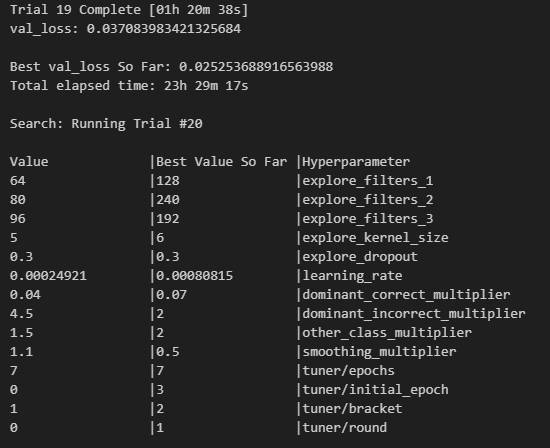

In [11]:
search_space = tuner.search_space_summary()
print(search_space)

Search space summary
Default search space size: 10
explore_filters_1 (Choice)
{'default': 128, 'conditions': [], 'values': [64, 128, 192], 'ordered': True}
explore_filters_2 (Choice)
{'default': 160, 'conditions': [], 'values': [80, 160, 240], 'ordered': True}
explore_filters_3 (Choice)
{'default': 192, 'conditions': [], 'values': [96, 192, 288], 'ordered': True}
explore_kernel_size (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 6, 7, 9], 'ordered': True}
explore_dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dominant_correct_multiplier (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.01, 'sampling': 'linear'}
dominant_incorrect_multiplier (Float)
{'default': 1.0, 'conditions': [], 'min_value': 1.0, 'max_value': 5.0, 'step': 0.5, '

In [11]:
results = tuner.results_summary(num_trials=17)
print(results)

Results summary
Results in DCNN_Tuner_2/dcnn_hyperparam_opt
Showing 17 best trials
Objective(name="val_loss", direction="min")

Trial 0015 summary
Hyperparameters:
explore_filters_1: 128
explore_filters_2: 240
explore_filters_3: 192
explore_kernel_size: 7
explore_dropout: 0.2
learning_rate: 0.0006232206265540669
dominant_correct_multiplier: 0.06
dominant_incorrect_multiplier: 2.5
other_class_multiplier: 1.5
smoothing_multiplier: 0.5
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0000
Score: 0.025108424946665764

Trial 0012 summary
Hyperparameters:
explore_filters_1: 128
explore_filters_2: 160
explore_filters_3: 288
explore_kernel_size: 9
explore_dropout: 0.2
learning_rate: 0.0006860211454828152
dominant_correct_multiplier: 0.06999999999999999
dominant_incorrect_multiplier: 2.5
other_class_multiplier: 2.0
smoothing_multiplier: 0.5
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0009
Score: 0.02514969557523727

In [12]:
tuner.search(train_dataset, epochs=20, steps_per_epoch = steps_per_epoch, validation_data=val_dataset, callbacks=[stop_early, CleanupCallback(), TimeLimit(max_time_seconds=max_time_seconds)])

Trial 21 Complete [00h 20m 35s]
val_loss: 0.030874434858560562

Best val_loss So Far: 0.024632375687360764
Total elapsed time: 08h 36m 40s

Search: Running Trial #22

Value             |Best Value So Far |Hyperparameter
128               |128               |explore_filters_1
160               |160               |explore_filters_2
288               |288               |explore_filters_3
6                 |9                 |explore_kernel_size
0.2               |0.2               |explore_dropout
0.00029791        |0.00068602        |learning_rate
0.08              |0.07              |dominant_correct_multiplier
3.5               |2.5               |dominant_incorrect_multiplier
2                 |2                 |other_class_multiplier
0.5               |0.5               |smoothing_multiplier
7                 |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2             

KeyboardInterrupt: 

In [ ]:
# tuner.run_trial()

In [ ]:
max_time_seconds = 60  # 1 hour is 3600 seconds
batch_size = 28
epochs = 100  # Set high enough to allow stopping by time
steps_per_epoch = 7178

print('Compiling train dataset')
train_dataset = prep_dataset_from_tfrecord(datasets_path + "TestValTrain/train.tfrecord.gz",
                                batch_size=batch_size, 
                                compression_type='GZIP', 
                                shuffled=True,
                                shuffle_buffer=10000,
                                total_records=200985,
                                num_to_drop=1 # Batch size 28 leaves remainder of 1 record
                                )

for X_batch, y_batch in train_dataset.take(1):
    print("X shape:", X_batch.shape)
    print("y shape:", y_batch.shape)
    # print("record_id:", record_id_batch)
    # print("cstart:", cstart_batch)
    # print("cend:", cend_batch)
    # print("strand:", strand_batch)

Compiling train dataset
X shape: (28, 5000, 5)
y shape: (28, 5000, 5)


2025-02-09 22:11:57.955635: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


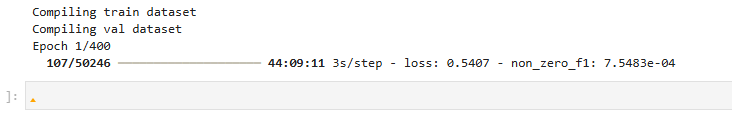

^ The best free AWS training can get you